<h1 style="text-align: center;">MODELING (ENSEMBLE MODEL)</h1>

### Import the libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn 
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn.functional as F

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from joblib import load
import os
from typing import Union, Tuple

### Load the Data (Oversampled & Imbalanced)

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/serialized-uti-dataset/preprocessed_unscaled_data.joblib
/kaggle/input/serialized-uti-dataset/preprocessed_data.joblib
/kaggle/input/mlp-parameters/mlp_parameters_tensor.pth
/kaggle/input/serialized-uti-dataset-imbalanced/preprocessed_unscaled_data.joblib
/kaggle/input/serialized-uti-dataset-imbalanced/preprocessed_data.joblib
/kaggle/input/lgbm-model/best_model.joblib


### Concatinate the Test Data from Oversampled & Imbalanced

In [3]:
# Load the test data
_, X_TEST_OVERSAMPLED, _, Y_TEST_OVERSAMPLED = load(r"/kaggle/input/serialized-uti-dataset/preprocessed_data.joblib")
_, X_TEST_IMBALANCED, _, Y_TEST_IMBALANCED = load(r"/kaggle/input/serialized-uti-dataset-imbalanced/preprocessed_data.joblib")

# concatinate the oversampled and imbalanced tests data
X_TEST = pd.concat([X_TEST_OVERSAMPLED, X_TEST_IMBALANCED])
Y_TEST = pd.concat([Y_TEST_OVERSAMPLED, Y_TEST_IMBALANCED])

### Load the Light Gradient Boosting Machine (LGBM)

In [4]:
LGBM_MODEL = load(r"/kaggle/input/lgbm-model/best_model.joblib")

### Load the Multi-Layer Perceptron (MLP)

In [5]:
class ClassifierNN(nn.Module):
    """
        Neural network classifier.

        Parameters
        ----------
        activation_function : torch.nn.Module
            The activation function to be used in the network.

        Attributes
        ----------
        activation_function : torch.nn.Module
            The activation function for the network.
        fcn1 : torch.nn.Linear
            The first fully connected layer with input size 14 and output size 32.
        fcn2 : torch.nn.Linear
            The second fully connected layer with input size 32 and output size 64.
        fcn3 : torch.nn.Linear
            The third fully connected layer with input size 64 and output size 128.
        fcn4 : torch.nn.Linear
            The fourth fully connected layer with input size 128 and output size 2.

        Methods
        -------
        forward(x)
            Forward pass of the neural network.

    """

    def __init__(self):
        super().__init__()
        OPTIMAL_ACTIVATION_FUNCTION = F.relu

        self.activation_function = OPTIMAL_ACTIVATION_FUNCTION

        # Define fully connected layers
        self.fcn1 = nn.Linear(14, 32)
        self.fcn2 = nn.Linear(32, 64)
        self.fcn3 = nn.Linear(64, 128)
        self.fcn4 = nn.Linear(128, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
            Forward pass of the neural network.

            Parameters
            ----------
            x : torch.Tensor
                Input tensor with shape (-1, 14).

            Returns
            -------
            torch.Tensor
                Output tensor after the forward pass.
        """
        x = x.view(-1, 14)

        x = self.activation_function(self.fcn1(x))
        x = self.activation_function(self.fcn2(x))
        x = self.activation_function(self.fcn3(x))

        x = self.fcn4(x)

        return x

In [6]:
MLP_MODEL = ClassifierNN()

MLP_MODEL.load_state_dict(torch.load(r"/kaggle/input/mlp-parameters/mlp_parameters_tensor.pth"))

<All keys matched successfully>

### Predicting Label Probabilities (LGBM)

In [7]:
LGBM_YHAT_PROBA = LGBM_MODEL.predict_proba(X_TEST)

In [8]:
LGBM_YHAT_PROBA[:10]

array([[9.99447534e-01, 5.52465926e-04],
       [9.99315464e-01, 6.84536342e-04],
       [9.99257299e-01, 7.42700582e-04],
       [9.99384495e-01, 6.15504644e-04],
       [9.99308376e-01, 6.91624360e-04],
       [9.93680685e-01, 6.31931534e-03],
       [9.99405920e-01, 5.94080101e-04],
       [9.99433993e-01, 5.66006833e-04],
       [5.24531612e-02, 9.47546839e-01],
       [9.99384495e-01, 6.15504644e-04]])

### Predicting Label Probabilities (MLP)

In [10]:
class UTIDataset(Dataset):
    def __init__(self, df, transform=None):
        """
            Custom PyTorch dataset for the UTI dataset.

            Parameters
            ----------
            df : pandas.DataFrame
                The dataset as a DataFrame.
            transform : callable, optional
                A function to apply transformations on input features and labels, default is None.
        """
        self.df = df
        self.transform = transform

    def __len__(self):
        """
            Get the length of the dataset.

            Returns
            -------
            int
                The number of samples in the dataset.
        """
        return len(self.df)

    def __getitem__(self, idx: int) -> Tuple[Union[torch.Tensor, torch.Tensor]]:
        """
            Get a specific sample from the dataset.

            Parameters
            ----------
            idx : int
                Index of the sample to retrieve.

            Returns
            -------
            tuple
                A tuple containing the input features and labels.
        """
        # Extract features and labels from the DataFrame
        x = self.df.iloc[idx, :-1].values.astype("float32").reshape((self.df.columns.__len__() - 1, 1))
        y = self.df.iloc[idx, -1:].values.astype("long").reshape((1, 1))

        # Apply transformations if provided
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)

        return x, y

In [11]:
# Define a transformation using torchvision"s ToTensor()
TRANSFORM = transforms.ToTensor()

X_TEST_RESET = X_TEST.reset_index(drop=True)
Y_TEST_RESET = Y_TEST.reset_index(drop=True)

# Concatenate features and labels for training and testing sets
TEST_DF = pd.concat([X_TEST_RESET, Y_TEST_RESET], axis=1)

# Create an instance of the UTIDataset with the whole dataset and the specified transform
TEST_DATA = UTIDataset(TEST_DF, TRANSFORM)

In [12]:
# Define batch size
BATCH_SIZE = 16

# Data Loader
TEST_LOADER = DataLoader(TEST_DATA, batch_size=BATCH_SIZE)

In [13]:
# Check if CUDA (GPU) is available, and set the device accordingly
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
predicted_proba = []

# Set the model in evaluation mode (no gradient computation)
MLP_MODEL.eval()

# Disable gradient computation during inference
with torch.no_grad():
    # Iterate over batches in the test DataLoader
    for val_X, _ in TEST_LOADER:
        # Move input data and labels to the selected device
        val_X = val_X.to(DEVICE)

        # Forward pass through the neural network
        OUTPUTS = MLP_MODEL(val_X)

        PROBABILITIES = F.softmax(OUTPUTS, dim=1)

        # Extend the list of probabilities
        predicted_proba.extend(PROBABILITIES.cpu().numpy())

# Convert the final list to a NumPy array if needed
predicted_proba = np.array(predicted_proba)

### Soft Voting

In [15]:
NUM_OF_MODELS = 2
MODELS_AVERAGE_PREDICTIONS = (LGBM_YHAT_PROBA + predicted_proba) / NUM_OF_MODELS

In [16]:
MODELS_LABELED_PREDICTIONS = np.argmax(MODELS_AVERAGE_PREDICTIONS, axis=1)

### Evaluating the Predictions from Soft Voting

In [17]:
# Compute evaluation metrics using scikit-learn functions
ACCURACY = accuracy_score(Y_TEST, MODELS_LABELED_PREDICTIONS)
F1 = f1_score(Y_TEST, MODELS_LABELED_PREDICTIONS)
RECALL = recall_score(Y_TEST, MODELS_LABELED_PREDICTIONS)
PRECISION = precision_score(Y_TEST, MODELS_LABELED_PREDICTIONS)

# Compute additional metrics (confusion matrix, specificity, ROC AUC)
TN, FP, _, _ = confusion_matrix(Y_TEST, MODELS_LABELED_PREDICTIONS).ravel()
SPECIFICITY = TN / (TN + FP)
ROC_AUC = roc_auc_score(Y_TEST, MODELS_LABELED_PREDICTIONS)

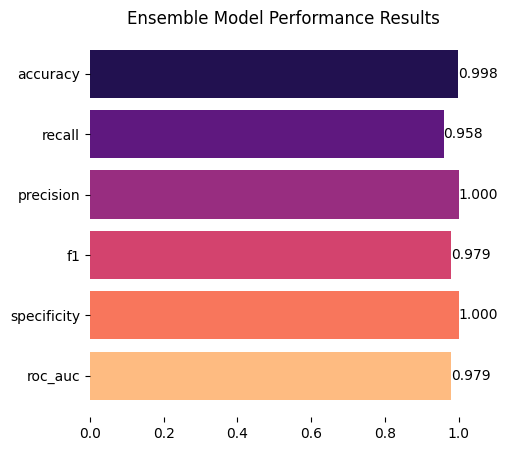

In [19]:
# Create a horizontal bar plot
_, axs = plt.subplots(figsize=(5, 5))

# Plot horizontal bar graph with performance metrics
bar_graph = axs.barh(["accuracy", "recall", "precision", "f1", "specificity", "roc_auc"],
                      [ACCURACY, RECALL, PRECISION, F1, SPECIFICITY, ROC_AUC],
                      color=sns.color_palette(palette="magma"))

# Add labels to the bars with the corresponding values
CONTAINER = axs.containers[0]
axs.bar_label(bar_graph, labels=[f"{x:,.3f}" for x in CONTAINER.datavalues])

# Remove spines for aesthetics
for s in ["top", "bottom", "left", "right"]:
    axs.spines[s].set_visible(False)

# Invert y-axis for better visualization
axs.invert_yaxis()

# Set plot title and display the plot
plt.title("Ensemble Model Performance Results")
plt.show()